# Audio Signal Processing and Reconstruction

This notebook demonstrates audio signal processing using **Random Fourier Features (RFF)** and linear regression. The goal is to reconstruct an audio waveform and evaluate the reconstruction quality.

### Steps:
1. **Loading the Audio File:**
   - Audio is loaded using `torchaudio.load()` which returns the audio data and sampling rate. The audio is cropped to 5 seconds for processing.
   
2. **Mapping Audio to the Time Domain:**
   - The audio is treated as a time series, and the time steps are normalized to the range $[-100, 100]$.

3. **Random Fourier Features (RFF) Transformation:**
   - The **Gaussian kernel** is approximated using **RFF**, transforming the input into a high-dimensional feature space, enabling linear regression in this expanded domain. Here, 8000 features are used, and the bandwidth is controlled by the parameter \(\sigma = 0.01$.

4. **Fitting a Linear Regression Model:**
   - A linear regression model is trained on the RFF-expanded features to map the time-series data to the audio amplitudes.

5. **Saving and Reconstructing Audio:**
   - The trained model is saved, and predictions are made to reconstruct the audio signal. The reconstructed audio is saved as a `.wav` file.

6. **Reconstructed Audio and Loss Calculations:**
   - The original and reconstructed audio waveforms are compared visually, and **L1** and **L2** reconstruction losses are computed. Additionally, **RMSE** and **PSNR** metrics are calculated to assess the reconstruction quality.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile
from IPython.display import Audio
%matplotlib inline
%config InlineBackend.figure_format = "retina"


# Utility Functions

In [2]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

# RMSE Calculation
def calculate_rmse(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    rmse = np.sqrt(mse)
    return rmse

# SNR Calculation
def calculate_snr(original, noise):
    signal_power = np.mean(original ** 2)
    noise_power = np.mean(noise ** 2)
    if noise_power == 0:
        return float('inf')
    snr = 10 * np.log10(signal_power / noise_power)
    
    return snr



### Load the Audio File

In [3]:
import torchaudio
audio, sr = torchaudio.load('/audio/freebird.wav')

$ \text{Sampling Frequency} = \frac{\text{No. of Samples}}{\text{Time Taken}} $

In [4]:
# Sampling frequency of the audio
print(f"Sampling Frequency (Sampling Rate): {sr} Hz")

Sampling Frequency (Sampling Rate): 44100 Hz


In [5]:
print(f"Original Audio Shape: {audio.shape}")

# Select the first element from the audio array
audio = audio[0]

# Print the updated shape after selecting the first element
print(f"Updated Audio Shape after selecting the first channel: {audio.shape}")

Original Audio Shape: torch.Size([2, 220655])
Updated Audio Shape after selecting the first channel: torch.Size([220655])


Audio length: 5.003514739229025 seconds
Cropped Audio length: 5.0 seconds
torch.Size([220500])
Plotting the final audio waveform


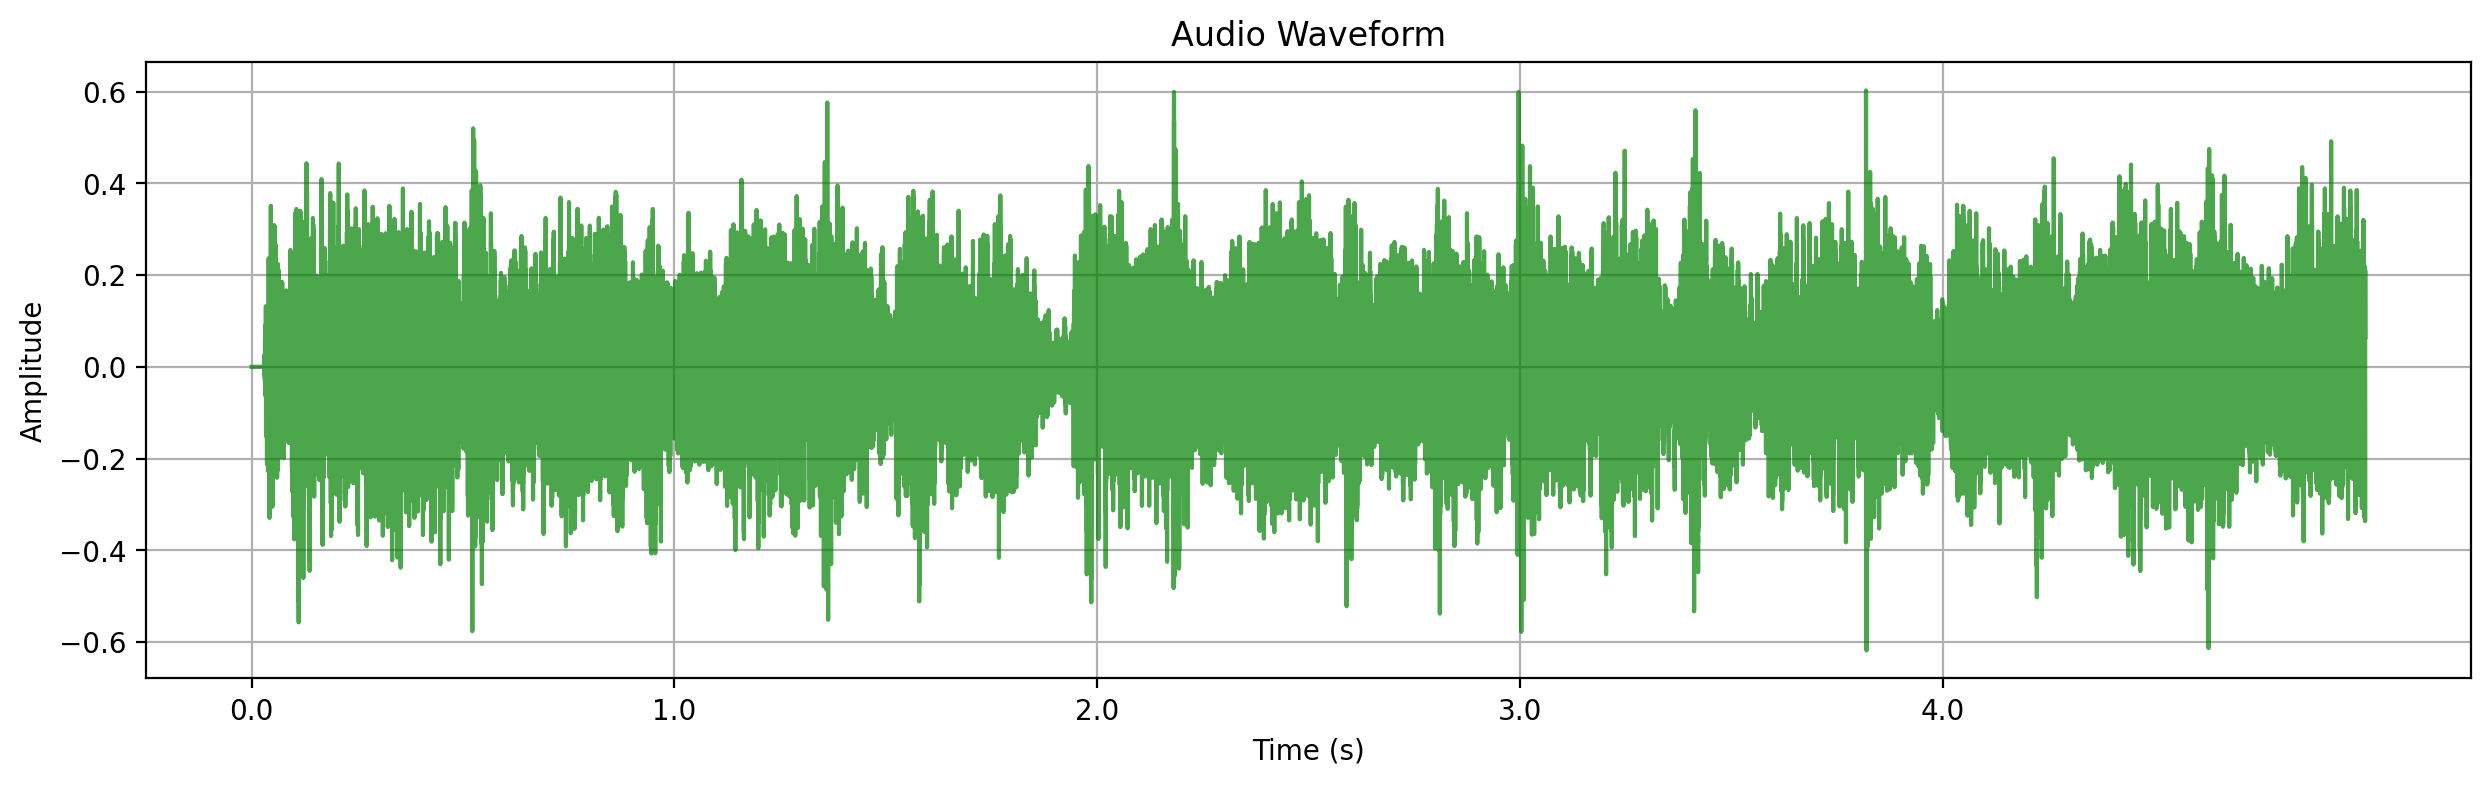

In [6]:
# We crop the audio to precisely 5 seconds. We can do this by dividing the number of audio samples by the sampling rate

tm = audio.shape[0] / sr # dividing number of audio samples by sampling rate gives us the time
print(f"Audio length: {tm} seconds")
audio = audio[-5 * sr:] # Cropping to precisely 5 seconds of audio 
tm = audio.shape[0] / sr # dividing number of audio samples by sampling rate gives us the time
print(f"Cropped Audio length: {tm} seconds")
print(audio.shape)
print("Plotting the final audio waveform")
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [7]:
Audio(audio, rate = sr)

### Plotting the Audio Waveform

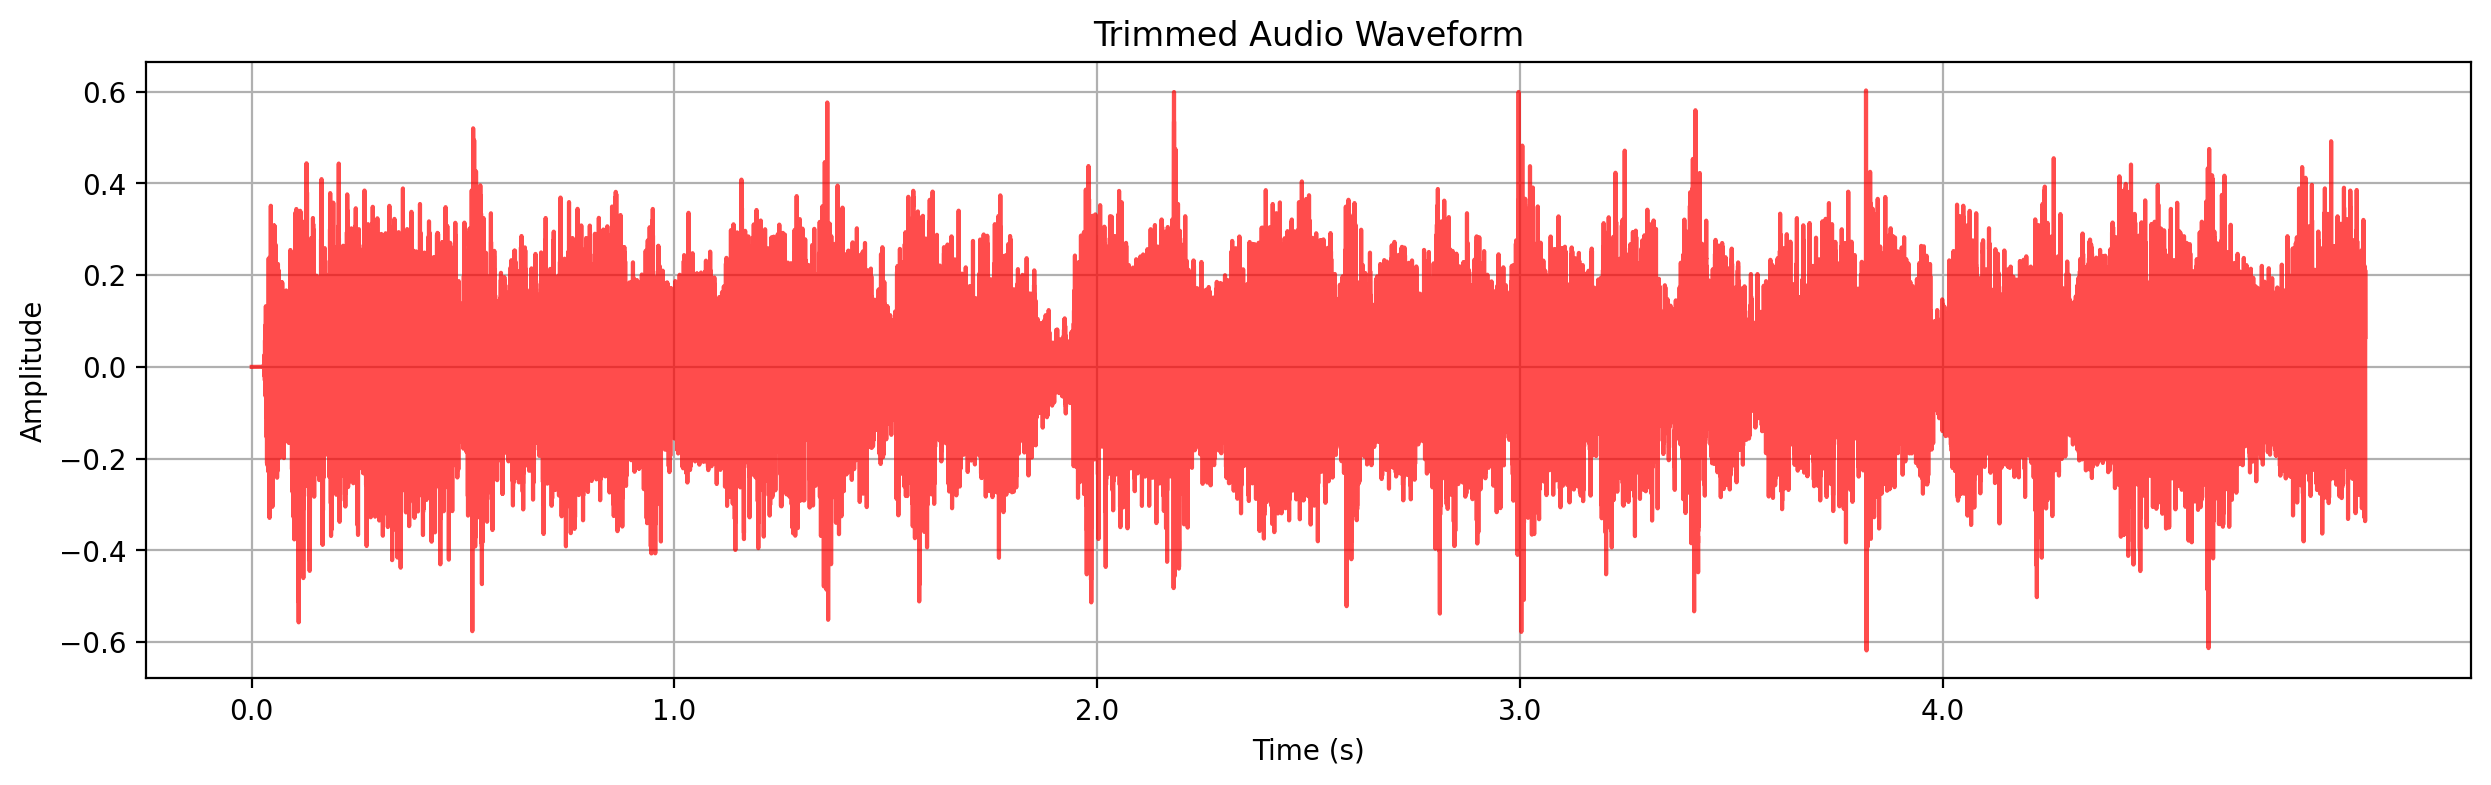

In [8]:
audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')

### Creating the Time Series $t = [-100.0, \cdots, 100.0]$ domain shifted to $[-100, 100]$

In [9]:
# Create a tensor with integer values ranging from 0 to len(audio) - 1
X = torch.arange(0, len(audio)).unsqueeze(1).float()

# Normalize the tensor by dividing by the maximum value of X, scaling it to the range [0, 200], and shifting it to [-100, 100]
X = X / X.max() * 200 - 100

# Print the shape of X to check the dimensions after reshaping
print(X.shape)

# Print the values in X to see the transformed time steps
print(X)


torch.Size([220500, 1])
tensor([[-100.0000],
        [ -99.9991],
        [ -99.9982],
        ...,
        [  99.9982],
        [  99.9991],
        [ 100.0000]])


### Gaussian Kernel and Random Fourier Features

#### The Gaussian Kernel
$$ K(\textbf{x}, \textbf{x}') = \exp{(-\gamma \lVert \textbf{x} - \textbf{x}' \rVert^2)}, \gamma = \frac{1}{2\sigma^2}$$

#### Since this is infinte dimensional, it can approximated with the **Fourier Transform** of this kernel

$$\gamma(\mathbf{v}) = [\cos({2 \pi \mathbf{B}\mathbf{v}}), \sin({2 \pi \mathbf{B}\mathbf{v}})]^T $$
$$ \mathbf{v} \in \mathbb{R}^{\text{input}} $$
Each entry in $\mathbf{B} \in \mathbb{R}^{m \times \text{input}}$ is sampled from $\mathcal{N}(0, \sigma^2 I)$
$$ \gamma(\mathbf{v}) = [a_1 \cos({2 \pi \mathbf{b}_1^T\mathbf{v}}), a_1 \sin({2 \pi \mathbf{b}_1^T\mathbf{v}}), \cdots, a_m \cos({2 \pi \mathbf{b}_m^T\mathbf{v}}), a_m \sin({2 \pi \mathbf{b}_m^T\mathbf{v}})]^T $$

In [10]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [11]:
num_features = 10000
sigma = 0.010

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([220500, 10000])
tensor([[ 0.0141, -0.0141,  0.0101,  ..., -0.0129,  0.0141, -0.0132],
        [ 0.0141, -0.0139,  0.0101,  ..., -0.0132,  0.0139, -0.0124],
        [ 0.0139, -0.0137,  0.0102,  ..., -0.0136,  0.0133, -0.0115],
        ...,
        [-0.0116,  0.0051, -0.0138,  ..., -0.0057, -0.0088,  0.0065],
        [-0.0111,  0.0060, -0.0138,  ..., -0.0048, -0.0104,  0.0048],
        [-0.0105,  0.0068, -0.0138,  ..., -0.0039, -0.0117,  0.0031]])


## Fitting a Linear Model over this expanded feature domain

In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(220500,)


### Saving the model weights and sound file

In [13]:
import joblib
import soundfile as sf

# Save model to 'audio' directory
joblib.dump(model, 'audio/model.pkl')

# Load model from 'audio' directory
model = joblib.load('audio/model.pkl')

# Save predicted audio to 'audio' directory
sf.write('audio/pred_audio.wav', pred_audio, sr)

In [14]:
print(pred_audio)
print(audio)

[-0.04962677 -0.02950805 -0.02415222 ...  0.08420044  0.10003906
  0.072146  ]
tensor([0.0000, 0.0000, 0.0000,  ..., 0.0803, 0.0707, 0.0654])


## Reconstructed Audio

In [15]:
Audio(pred_audio, rate = sr)

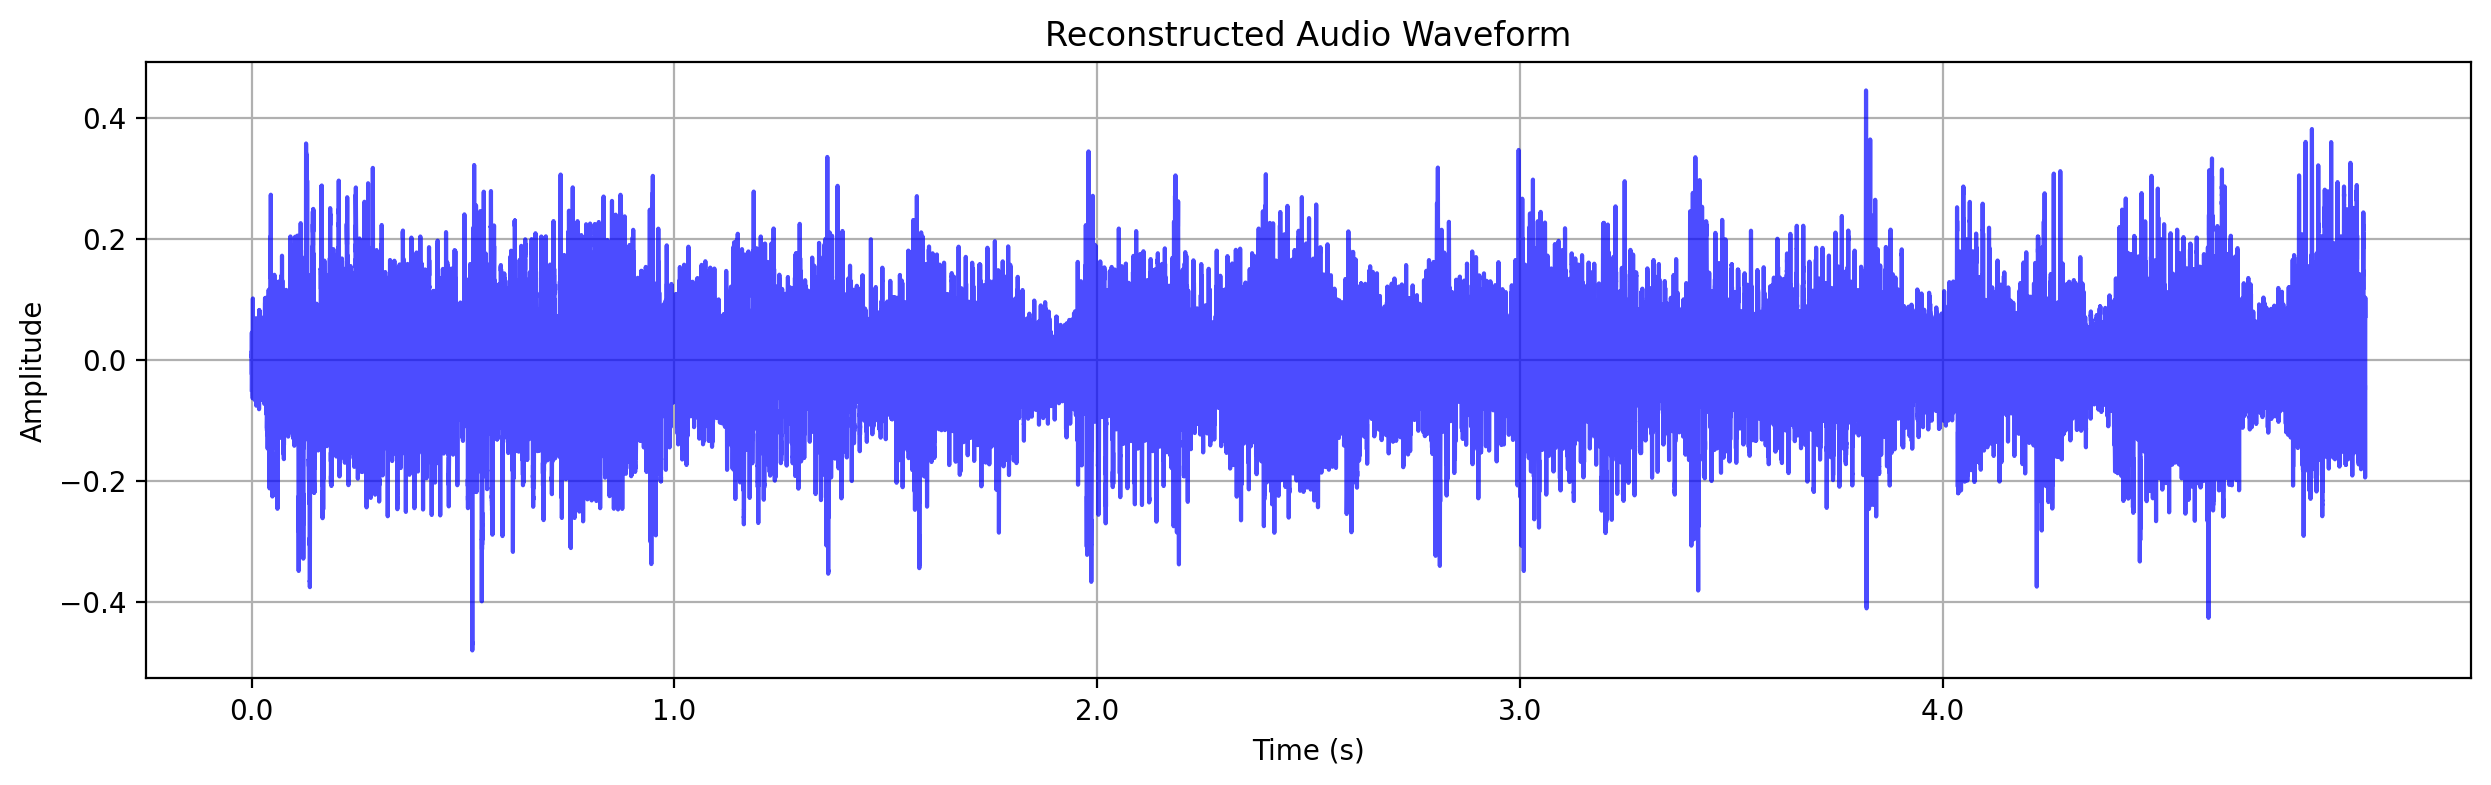

In [16]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

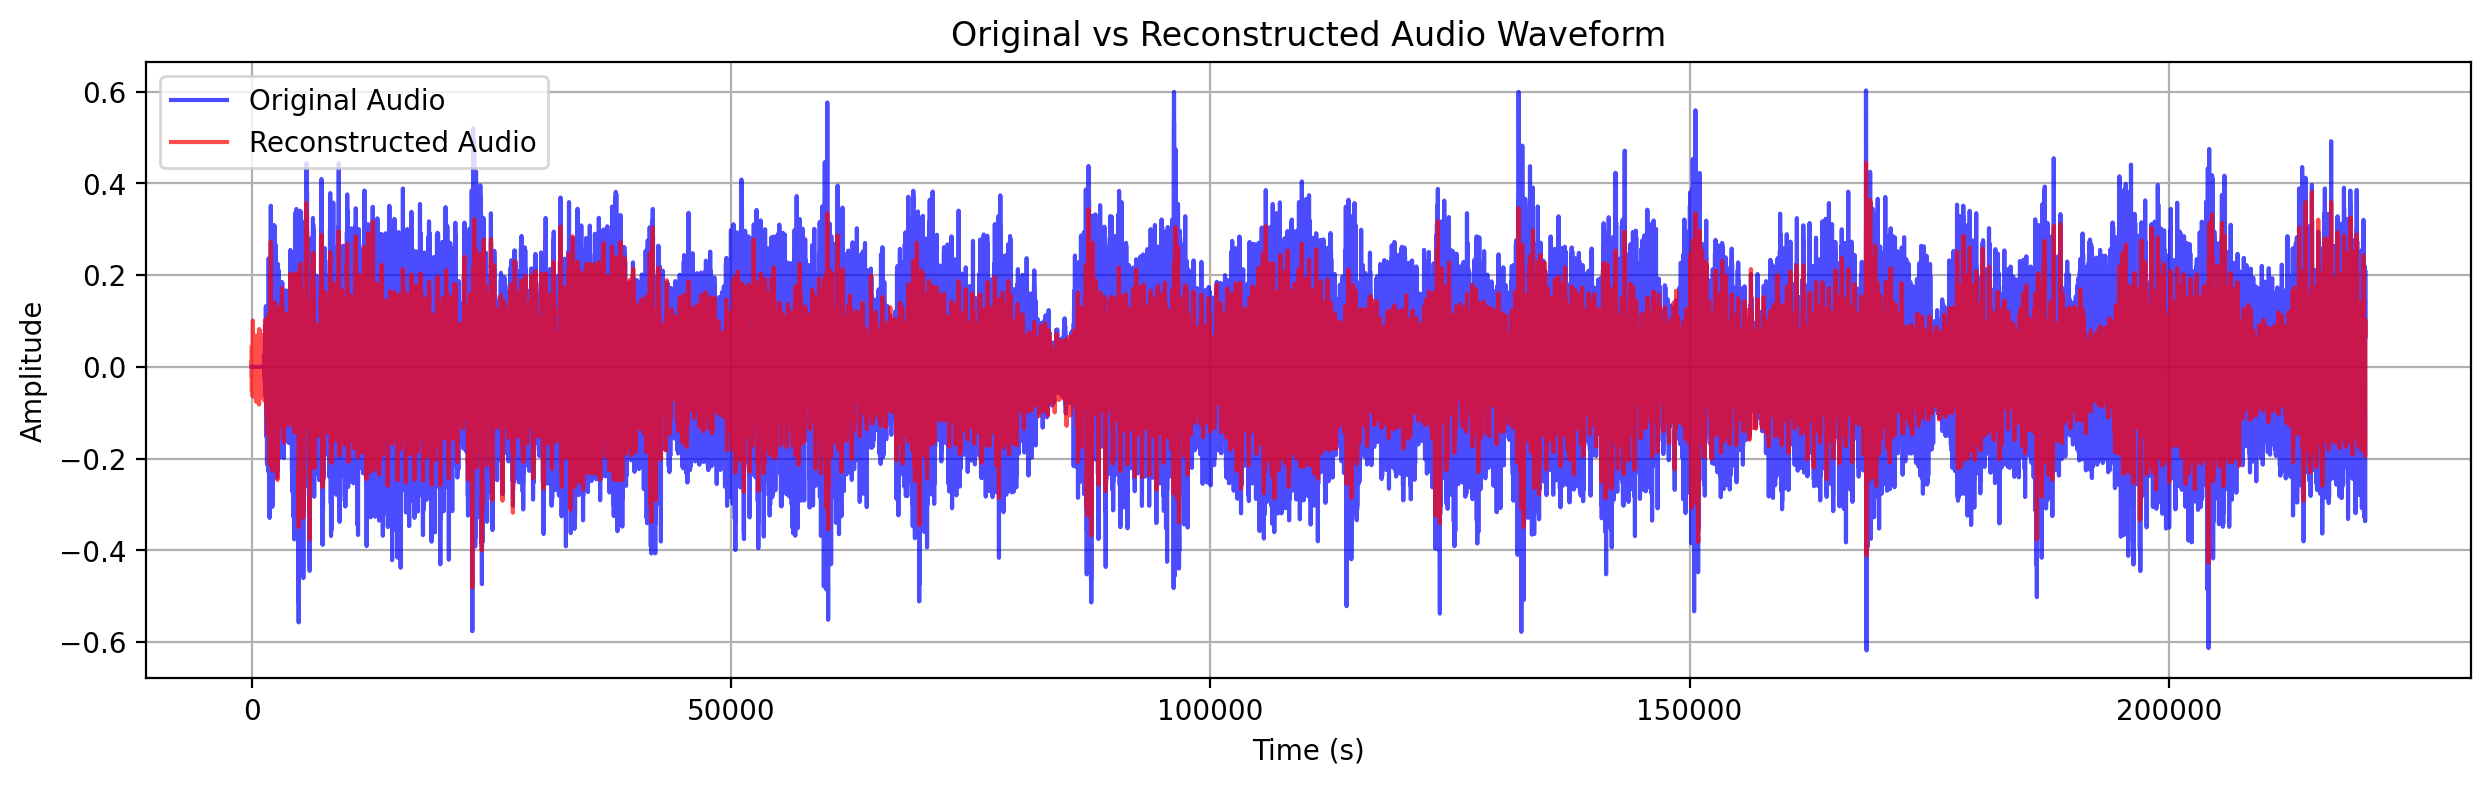

In [17]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

### Reconstruction Losses ($L_1$ and $L_2$)
$$ L_1 = \lVert \text{Reconstructed} - \text{Original} \rVert_1 $$
$$ L_2 = \lVert \text{Reconstructed} - \text{Original} \rVert_2 $$

### RMSE (Root Mean Squared Error)
The RMSE measures the square root of the average squared differences between the predicted and the original values. 

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\text{original}_i - \text{compressed}_i)^2}
$$

Where $n$ is the number of samples, $\text{original}_i$ is the original signal value, and $\text{compressed}_i$ is the reconstructed signal value.

### SNR (Signal-to-Noise Ratio)

SNR is a metric used to evaluate the quality of a reconstructed signal (audio in our case) by comparing it to the original signal. It is expressed in **decibels (dB)**, with higher SNR values indicating better reconstruction quality (less noise).

$$
\text{SNR} = 10 \cdot \log_{10} \left( \frac{P_{\text{signal}}}{P_{\text{noise}}} \right)
$$

Where:
- $ P_{\text{signal}} $ is the power of the original signal.
- $ P_{\text{noise}} $ is the power of the noise, defined as the difference between the original and reconstructed signals.

The power of the signal and noise is typically computed as the **mean squared value** of the signal and noise, respectively:

$$
P_{\text{signal}} = \frac{1}{n} \sum_{i=1}^{n} (\text{original}_i)^2
$$

$$
P_{\text{noise}} = \frac{1}{n} \sum_{i=1}^{n} (\text{original}_i - \text{reconstructed}_i)^2
$$

In this formula:
- $ n $ is the total number of data points (samples in the signal).
- $ \text{original}_i $ is the value of the original signal at point $ i $.
- $ \text{reconstructed}_i $ is the value of the reconstructed signal at point $ i $.

### Interpretation:
- A **higher SNR** indicates that the noise (error between original and reconstructed signals) is low, and the reconstructed signal closely matches the original.
- A **lower SNR** means the noise is high, implying poor reconstruction quality.


In [18]:
# Calculate L1 reconstruction loss
l1_loss = np.linalg.norm(pred_audio - audio.numpy(), ord=1)
# Calculate L2 reconstruction loss
l2_loss = np.linalg.norm(pred_audio - audio.numpy())
print(f"L1 Reconstruction Loss: {l1_loss}")
print(f"L2 Reconstruction Loss: {l2_loss}")

# Compute RMSE and PSNR
rmse = calculate_rmse(audio.numpy(), pred_audio)
snr = calculate_snr(audio.numpy(), pred_audio)

print(f"RMSE: {rmse}")
print(f"SNR: {snr}")

L1 Reconstruction Loss: 13407.7734375
L2 Reconstruction Loss: 35.97233963012695
RMSE: 0.07660630345344543
SNR: 2.2720371186733246
